# TP 1: Bayesian Linear Regression


                  Valentyn Gerushta, Léane Salais


During this session, we will work with Bayesian Linear Regression models with varying basis functions (linear, polynomial and Gaussian). Datasets used are 1D toy regression samples ranging from linear datasets to more complex non-linear datasets such as increasing sinusoidal curves.

**Goal**: Take hand on simple Bayesian models, understand how it works, gain finer insights on predictive distribution.



    # TODO OFFICIEL
    Distribution prédictive avec la Bayesian linear regression => [Question 1.3]
    résultats de la distribution prédictive sur le dataset
    analyse théorique justifiant la forme de la distribution (cas simple alpha=0, beta=1) 

In [ ]:
#@title Import libs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#@title Useful plot function
# Useful function: plot results
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45):
    """Given a dataset and predictions on test set, this function draw 2 subplots:
    - left plot compares train set, ground-truth (test set) and predictions
    - right plot represents the predictive variance over input range
    
    Args:
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      X_test: (array) test inputs, sized [N,]
      y_test: (array) test labels, sized [N, ]
      y_pred: (array) mean prediction, sized [N, ]
      std_pred: (array) std prediction, sized [N, ]
      xmin: (float) min value for x-axis on left and right plot
      xmax: (float) max value for x-axis on left and right plot
      ymin: (float) min value for y-axis on left plot
      ymax: (float) max value for y-axis on left plot
      stdmin: (float) min value for y-axis on right plot
      stdmax: (float) max value for y-axis on right plot
      
    Returns:
      None
    """
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='red', label="BLR Poly")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred, color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred-std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred+std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred-std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred+std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = stdmin, ymax = stdmax)
    plt.plot(X_test, std_pred**2, color='red', label="\u03C3² {}".format("Pred"))

    # Get training domain
    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1]>1:
            training_domain.append([current_min,sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])
    
    # Plot domain
    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray', label="Training area" if j==0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")   
    
    plt.legend()
    plt.show()

## Part I: Linear Basis function model

We start with a linear dataset where we will analyze the behavior of linear basis functions in the framework of Bayesian Linear Regression.

In [ ]:
#@title Hyperparameters for the linear model { form-width: "30%" }

SIG = 0.2 #@param
ALPHA = 2.0 #@param
NB_POINTS =25 #@param

In [ ]:
# Generate linear toy dataset
def f_linear(x, noise_amount, sigma):
    y = -0.3 + 0.5*x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount*noise

# Create training and test points
dataset_linear = {}
dataset_linear['X_train'] = np.random.uniform(0, 2, NB_POINTS)
dataset_linear['y_train'] = f_linear(dataset_linear['X_train'], noise_amount=1, sigma=SIG)
dataset_linear['X_test'] = np.linspace(-10,10, 10*NB_POINTS)
dataset_linear['y_test'] = f_linear(dataset_linear['X_test'], noise_amount=0, sigma=SIG)
dataset_linear['ALPHA'] = ALPHA
dataset_linear['BETA'] = 1/(2.0*SIG**2)

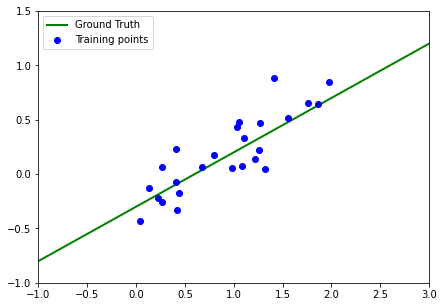

In [ ]:
# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmax = 3, xmin =-1)
plt.ylim(ymax = 1.5, ymin = -1)
plt.plot(dataset_linear['X_test'], dataset_linear['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_linear['X_train'], dataset_linear['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

### I.1 Bayesian prior and posterior 

We will use the linear basis function:
$ \phi:x \rightarrow 
    \begin{pmatrix} 
    1 \\ x 
    \end{pmatrix} 
$

Design matrix $\Phi$ defined on training set $\mathcal{D}=\{(x_n, y_n)\}_{n=1}^N$ is:
$$ \Phi=
  \begin{pmatrix}
    \phi(x_1)^T \\
    ... \\
    \phi(x_N)^T
  \end{pmatrix} =
  \begin{pmatrix}
    1 & x_1 \\
    ... & ...\\
    1 & x_N
  \end{pmatrix}
$$

In [ ]:
# Define the linear basis function

def phi_linear(x):
    """ Linear Basis Functions 
    Args:
      x: (float) scalar input
    Returns:
      (1D array) linear features of x
    """
    # ============ YOUR CODE HERE ============
    return np.vstack((np.ones(len(x)), x)).T

phi_linear(np.array([2,3,4])) # test

array([[1., 2.],
       [1., 3.],
       [1., 4.]])

**[Question 1.1] Recall the closed form of the posterior distribution in the linear case.**

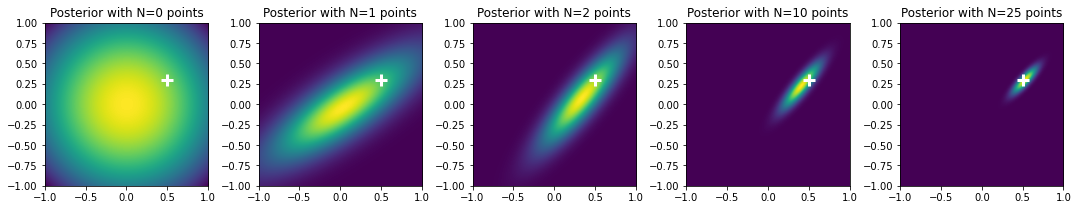

In [ ]:
# Compute mu and sigma to visualize posterior sampling

plt.figure(figsize=(15,7))
for count,n in enumerate([0,1,2,10,len(dataset_linear['X_train'])]):
    cur_data = dataset_linear['X_train'][:n]
    cur_lbl = dataset_linear['y_train'][:n]
    meshgrid = np.arange(-1, 1.01, 0.01)
    w = np.zeros((2,1))
    posterior = np.zeros((meshgrid.shape[0],meshgrid.shape[0]))
    
    # ============ YOUR CODE HERE ============
    # Compute sigma and mu
    # Don't forget the special case of zero data 
    # points, i.e prior

    if n == 0: # if no sample, it is just prior
        sigma = dataset_linear['ALPHA'] * np.eye(2)
        mu = np.zeros(2)
    else:
        phi_cur_data = phi_linear(cur_data)
        sigma = np.linalg.inv(dataset_linear['ALPHA'] * np.eye(2) + dataset_linear['BETA'] * np.dot(phi_cur_data.T, phi_cur_data))
        mu = dataset_linear['BETA'] * np.dot(np.dot(sigma, phi_cur_data.T), cur_lbl)
    sigmainv = np.linalg.inv(sigma)

    # Compute values on meshgrid
    for i in range(meshgrid.shape[0]):
        for j in range(meshgrid.shape[0]):
            w[0,0] = meshgrid[i]
            w[1,0] = meshgrid[j]
            posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu.reshape(2,1)).T, sigmainv) , (w-mu.reshape(2,1)) ) ) 
    Z = 1.0 / ( np.sqrt(2*np.pi* np.linalg.det(sigma) ) )
    posterior[:,:] /= Z
    
    # Plot posterior with n points
    plt.subplot(151+count)
    plt.imshow(posterior, extent=[-1,1,-1,1])
    plt.plot(0.5,0.3, '+', markeredgecolor='white', markeredgewidth=3, markersize=12)
    plt.title('Posterior with N={} points'.format(n))

plt.tight_layout()
plt.show()

**[Question 1.2] Looking at the visualization of the posterior above, what can you say?**

Les images représentent la distribution des paramètres (poids) $w0$ et $w1$ de la régression, connaissant plus ou moins de points d'entraînement - donc *a posteriori*. Dans tous les cas, la croix blanche représente les paramètres optimaux que le modèle devrait atteindre. Le comportement de ce posterior et son rapport à la croix blanche varient en fonction du nombre de points observés $N$. 

S'il n'y a pas de points d'entraînement, le posterior est égal au prior ; cela donne une gaussienne centrée sur 0 et d'écart type inversement proportionnel au paramètre du prior $\alpha$. Aucune chance d’estimer correctement les paramètres, la distribution est la plus incertaine possible, diffuse et mal centrée. 

**Dans les autres figures, on observe qu’en augmentant $N$, la distribution se centre sur la valeur exacte des paramètres - et surtout sa variance se réduit. Plus on ajoute d’exemples, plus on ajoute de l’évidence, et l’incertitude épistémique diminue.**

Sur la dernière image, avec $N = 25$, on approxime bien nos paramètres optimaux.  
__

*Note : la distribution des poids est ici lisible en 2D, ce qui est spécifique à la méthode bayésienne. Si on considérait un modèle déterministe (régression simple, réseau de neurones), on visualiserait à chaque fois juste un point (dans un espace à autant de dimensions que de poids à deviner). Ce point correspondrait au centre de nos gaussiennes 2D, par exemple $(0,0)$ pour $N=0$, et on constaterait là aussi une plus ou moins grande distance à la croix blanche.*

### I.2 Predictive variance 

**[Question 1.3] Recall the closed form of the predictive distribution in the linear case.**

In [ ]:
# Closed form solution according to the requirements on the left

def closed_form(func, X_train, y_train, alpha, beta):
    """Define an analytical solution to Bayesian Linear Regression, with respect to the chosen basis function, to the
    training set (X_train, y_train) and to the chosen noise precision parameter beta and prior precision parameter alpha.
    It should return a function outputing both mean and std of the predictive distribution at a point x*.
    Args:
      func: (function) the basis function used
      X_train: (array) train inputs, size (N,)
      y_train: (array) train labels, size (N,)
      alpha: (float) prior precision parameter
      beta: (float) noise precision parameter
    Returns:
      (function) prediction function, returning itself both mean and std
    """

    # ============ YOUR CODE HERE ============
    # Compute features and define mu and sigma  
    phi_X_train = func(X_train)
    nb_features = phi_X_train.shape[1]
    sigma_N = np.linalg.inv(alpha * np.eye(nb_features) + beta * np.dot(phi_X_train.T, phi_X_train))
    mu_N = beta * np.dot(np.dot(sigma_N, phi_X_train.T), y_train)
    def f_model(x):
        # ============ YOUR CODE HERE ============
        # Return closed form
        phi_x = func(x)
        mu_pred = np.dot(mu_N.reshape(nb_features, 1).T, phi_x.T)
        sigma_pred = np.sqrt(1/beta + np.dot(np.dot(phi_x, sigma_N), phi_x.T))
        return mu_pred, sigma_pred

    return f_model

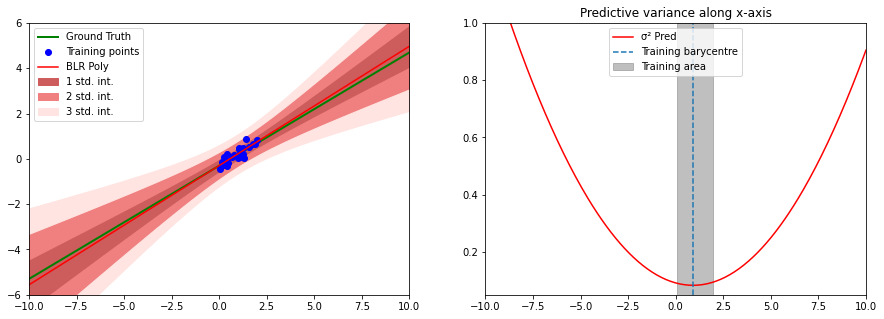

In [ ]:
# ============ YOUR CODE HERE ============

# Initialize predictive function
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'], 
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

# Predict on the test datapoints and use the visualization function
# defined at the beginning of the notebook
# You should use the following parameters for plot_results
# xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1

# Predict on test dataset
Y_pred, STD_pred = [], []
for x in dataset_linear['X_test']:
    y_pred, std_pred = f_pred([x])
    Y_pred.append(y_pred[0][0])
    STD_pred.append(std_pred[0][0])
Y_pred = np.array(Y_pred)
STD_pred = np.array(STD_pred)
    
Y_pred = np.array(Y_pred)
STD_pred = np.array(STD_pred)
plot_results(dataset_linear['X_train'], dataset_linear['y_train'], 
             dataset_linear['X_test'], dataset_linear['y_test'], Y_pred, STD_pred, 
             xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1)

**[Question 1.4] Analyse these results. Describe the behavior of the predictive variance for points far from training distribution. Prove it analytically in the case where $\alpha=0$ and $\beta=1$.**

À gauche, une visualisation de la prédiction du modèle (ligne rouge) versus la *ground truth* (ligne verte). Le modèle approxime plutôt bien la droite originale avec un léger décalage sur l’angle exact.  
Les aires en nuances de rouge représentent son incertitude : leur largeur est proportionnelle à la variance prédictive, or elles sont resserrées près des points d'entraînement et s’étendent plus loin, là où l'écart avec la *ground truth* s’accroît. **En mesurant cela, on peut donc comprendre même sans voir la ground truth que le modèle a des chances de se tromper là. C’est tout l’intérêt de la régression bayésienne.**

À droite, la projection de la variance prédictive sur une seule dimension pour plus de lisibilité. Dans la *training area*, l’algorithme est sûr de lui, la variance est faible et même minimale au niveau du barycentre des points d’entraînement ; elle augmente dès qu’on s’en éloigne et explose en l’absence totale de points. 

Pour l'explication analytique de ce phénomène, voir rapport joint.

### I.3 Bonus Question

**Bonus Question: What happens when applying Bayesian Linear Regression on the following dataset?**

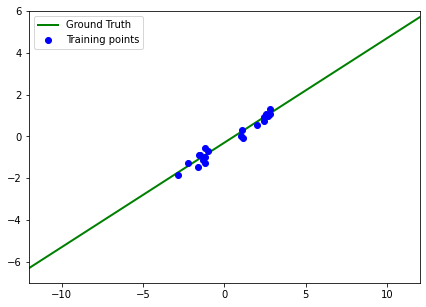

In [ ]:
# Create training and test points
dataset_hole = {}
dataset_hole['X_train'] = np.concatenate(([np.random.uniform(-3, -1, 10), np.random.uniform(1, 3, 10)]), axis=0)
dataset_hole['y_train'] = f_linear(dataset_hole['X_train'], noise_amount=1,sigma=SIG)
dataset_hole['X_test'] = np.linspace(-12,12, 100)
dataset_hole['y_test'] = f_linear(dataset_hole['X_test'], noise_amount=0,sigma=SIG)
dataset_hole['ALPHA'] = ALPHA
dataset_hole['BETA'] = 1/(2.0*SIG**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-12, xmax = 12)
plt.ylim(ymin = -7, ymax = 6)
plt.plot(dataset_hole['X_test'], dataset_hole['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_hole['X_train'], dataset_hole['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

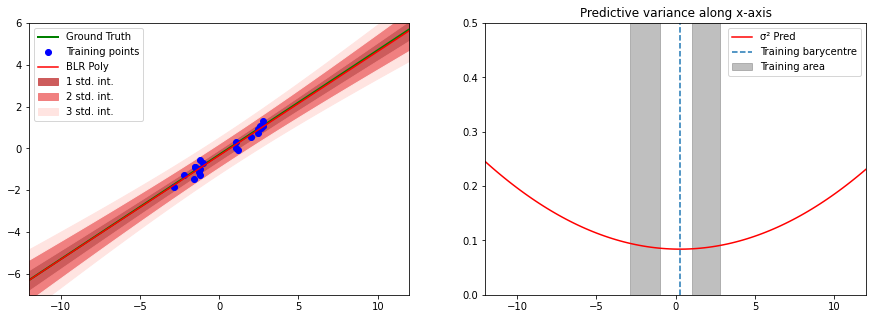

In [ ]:
# Define f_pred, predict on the test points and plot the results
f_pred = closed_form(phi_linear, dataset_hole['X_train'], dataset_hole['y_train'], 
                     dataset_hole['ALPHA'], dataset_hole['BETA'])

Y_pred, STD_pred = [], []
for x in dataset_hole['X_test']:
    y_pred, std_pred = f_pred([x])
    Y_pred.append(y_pred[0][0])
    STD_pred.append(std_pred[0][0])
Y_pred = np.array(Y_pred)
STD_pred = np.array(STD_pred)

# ============ YOUR CODE HERE ============
# Define a new f_pred, then predict on the test points 
# and use the visualization function as before
# You should use the following parameters for plot_results
# xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5
plot_results(dataset_hole['X_train'], dataset_hole['y_train'], 
             dataset_hole['X_test'], dataset_hole['y_test'], Y_pred, STD_pred, 
             xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5)

On avait constaté que la variance augmentait quand on s'éloignait des exemples (incertitude épistémique) et qu'elle était minimale au niveau du barycentre des points du jeu d'entraînement. Or ici, le dataset est coupé en deux. Le minimum est toujours au niveau du barycentre des points, mais il ne coïncide plus avec la *training area*...  
**Bien qu’on soit satisfait de l'augmentation de la variance un peu plus loin, il n'est pas normal qu'elle soit minimale dans un espace dépourvu de points (on ne peut pas deviner la ground truth à cet endroit). Forcément, c’est un effet non désiré, le modèle aurait dû montrer de l'incertitude.**

Sinon, on note que la région d'entraînement est plus étendue, donc le fit est par ailleurs plutôt bon.

## Part II: Non-linear models

We now introduce a more complex toy dataset, which is an increasing sinusoidal curve. The goal of this part is to get insight on the importance of the chosen basis function on the predictive variance behavior.

In [ ]:
## pour la partie 2.1, la valeur de D correspond à l'hyperparamètre NB_POLYNOMIAL_FEATURES défini au début de la section II

In [ ]:
#@title Hyperparameters for non-linear model { form-width: "30%" }

SIG = 0.2 #@param
ALPHA = 0.05 #@param
NB_POINTS = 50 #@param
NB_POLYNOMIAL_FEATURES = 10 #@param
MU_MIN = 0 #@param
MU_MAX = 1 #@param
NB_GAUSSIAN_FEATURES = 9 #@param

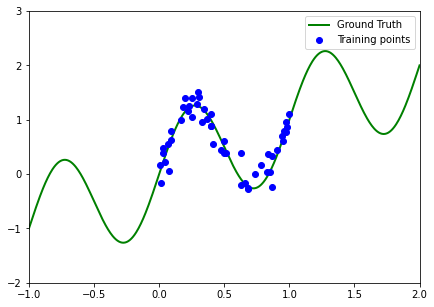

In [ ]:
# Generate sinusoidal toy dataset
def f_sinus(x, noise_amount,sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

# Create train and test points
dataset_sinus = {}
dataset_sinus['X_train'] = np.random.uniform(0, 1, NB_POINTS)
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1,sigma=SIG)
dataset_sinus['X_test'] = np.linspace(-1,2, 10*NB_POINTS)
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0,sigma=SIG)
dataset_sinus['ALPHA'] = ALPHA
dataset_sinus['BETA'] = 1/(2.0*SIG**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-1, xmax = 2)
plt.ylim(ymin = -2, ymax = 3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

### II.1 Polynomial basis functions

We will first use polynomial basis functions:
$$\phi:x \rightarrow 
  \begin{pmatrix}
    \phi_0 \\
    ... \\
    \phi_{D-1}
  \end{pmatrix}
$$
where $\phi_j = x^j$ for $j \geq 0$ and $D \geq 0$


Design matrix $\Phi$ defined on training set $\mathcal{D}$ is:
$$ \Phi=
  \begin{pmatrix}
    \phi(x_1)^T \\
    ... \\
    \phi(x_n)^T
  \end{pmatrix} =
  \begin{pmatrix}
    1 & x_1 & x_1^2 &... &x_1^{D-1} \\
    ... & ... & ... & ...\\
    1 & x_N & x_N^2 &... &x_N^{D-1}
  \end{pmatrix}
$$

In [ ]:
# Define a basis function
def phi_polynomial(x):
    """ Polynomial Basis Functions
    Args:
      x: (float) scalar input
    Returns:
      (1D-array) polynomial features of x
    """
    # ============ YOUR CODE HERE ============
    D = 10
    return np.hstack((np.ones(len(x))[:, np.newaxis], np.array([list(map(lambda x: x**i, x)) for i in range(1, D)]).T))

print(phi_polynomial(np.array([1,2])))

[[  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [  1.   2.   4.   8.  16.  32.  64. 128. 256. 512.]]


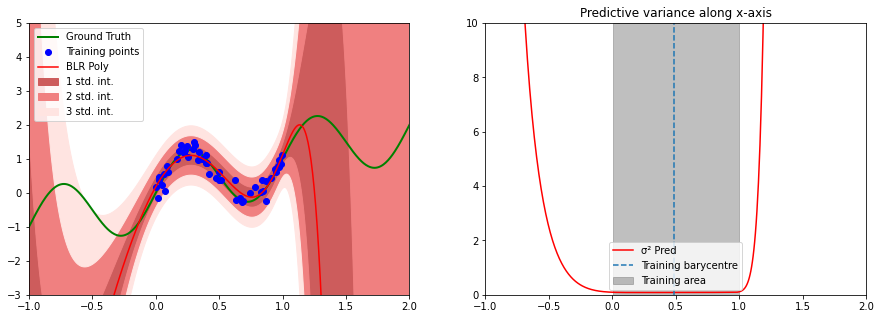

In [ ]:
# Implement closed form for polynomial features and visualise results

# ============ YOUR CODE HERE ============
# Define f_pred as the closed form for polynomial features
# with a sinusoidal dataset 
# Then, predict on the test points and use the visualization function
# defined at the beginning of the notebook
# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10

f_pred = closed_form(phi_polynomial, dataset_sinus['X_train'], dataset_sinus['y_train'], 
                                     dataset_sinus['ALPHA'], dataset_sinus['BETA'])
Y_pred, STD_pred = [], []
for x in dataset_sinus['X_test']:
    y_pred, std_pred = f_pred([x])
    Y_pred.append(y_pred[0][0])
    STD_pred.append(std_pred[0][0])
Y_pred = np.array(Y_pred)
STD_pred = np.array(STD_pred)

plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'], 
             dataset_sinus['X_test'], dataset_sinus['y_test'], Y_pred, STD_pred,
             xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10)

**[Question 2.1] What can you say about the predictive variance?**

Encore une fois, la variance prédictive explose en s'éloignant des données de train. Cela dit, le fait d'utiliser des features polynomiales change la position du minimum ; on peut maintenant parler de minimA sur toute la région des points d'entraînement. Sur le premier graphique, on constate ainsi que le fit du modèle est quasi-parfait sur cette zone (interpolation). 

**Mais dès lors qu'on en sort (extrapolation), l'approximation devient complètement fausse et la variance prédictive augmente très fort. Paramétriquement c'est attendu, on ne peut pas approximer une sinusoïde avec un polynôme de degré 10 et un training set aussi localisé.**

Note : on constate sur le deuxième graphique que la vitesse de cette augmentation n'est pas symétrique de part et d'autre des points d'entraînement. De fait, le fit ne l'est pas non plus, il est faux dans les deux cas mais s'éloigne plus ou moins vite de la *ground truth*. 

### II.2 Gaussian basis functions

Now, let's consider gaussian basis functions:
$$\phi:x \rightarrow 
  \begin{pmatrix}
    \phi_0 \\
    ... \\
    \phi_{D-1}
  \end{pmatrix}
$$
where $\phi_j = \exp \Big ( -\frac{(x-\mu_j)^2}{2s^2} \Big )$ for $j \geq 0$


Design matrix $\Phi$ defined on training set $\mathcal{D}$ is:
$$ \Phi=
  \begin{pmatrix}
    \phi_0(x_1) & \phi_1(x_1) &... &\phi_{D-1}(x_1) \\
    ... & ... & ... & ...\\
    \phi_0(x_N) & \phi_1(x_N) &... &\phi_{D-1}(x_N)
  \end{pmatrix}
  =
  \begin{pmatrix}
    e^{-\frac{(x_1-\mu_0)^2}{2s^2}} & e^{-\frac{(x_1-\mu_1)^2}{2s^2}} & ... & e^{-\frac{(x_1 - \mu_{D-1})^2}{2s^2}} \\
    ... & ... & ... & ...\\
    e^{-\frac{(x_N-\mu_0)^2}{2s^2}} & e^{-\frac{(x_N-\mu_1)^2}{2s^2}} &... & e^{-\frac{(x_N-\mu_{D-1})^2}{2s^2}} \\
  \end{pmatrix}  
$$

In [ ]:
# Define a Gaussian basis function

def phi_gaussian(x) :
    """ Gaussian Basis Functions defined linearly between 
    MU_MIN (=mu_0) and MU_MAX (=mu_{D-1})
    Args:
      x: (float) scalar input
    Returns:
      (1D-array) gaussian features of x
    """
    s = (MU_MAX-MU_MIN)/ NB_GAUSSIAN_FEATURES
    # ============ YOUR CODE HERE ============
    return np.array([np.exp(-(e - np.arange(MU_MIN, MU_MAX, s)) ** 2 / (2 * s * s)) for e in x])

print(phi_gaussian(np.array([2])))

[[4.40853133e-71 1.75568810e-63 2.57220937e-56 1.38634329e-49
  2.74878501e-43 2.00500878e-37 5.38018616e-32 5.31109225e-27
  1.92874985e-22]]


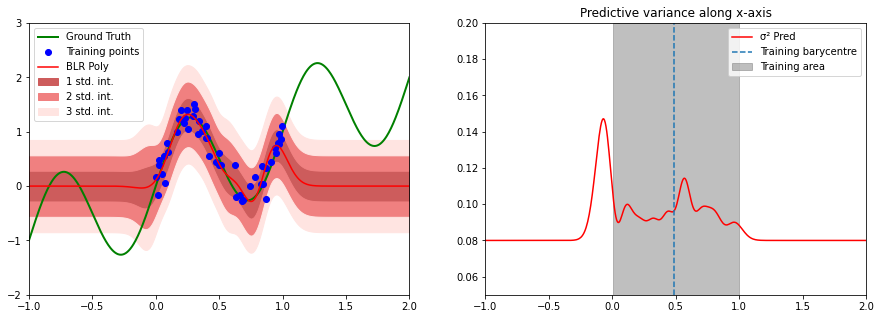

In [ ]:
# ============ YOUR CODE HERE ============
# Define f_pred as the closed form for Gaussian features
# with a sinusoidal dataset 
# Then, predict on the test points and use the visualization function
# defined at the beginning of the notebook
# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2

#Implement closed form for Gausian features and visualise results
f_pred = closed_form(phi_gaussian, dataset_sinus['X_train'], dataset_sinus['y_train'], 
                                   dataset_sinus['ALPHA'], dataset_sinus['BETA'])
Y_pred, STD_pred = [], []
for x in dataset_sinus['X_test']:
    y_pred, std_pred = f_pred([x])
    Y_pred.append(y_pred[0][0])
    STD_pred.append(std_pred[0][0])
Y_pred = np.array(Y_pred)
STD_pred = np.array(STD_pred)

plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'], 
             dataset_sinus['X_test'], dataset_sinus['y_test'], Y_pred, STD_pred,
             xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2)

**[Question 2.2] What can you say this time about the predictive variance? What can you conclude?**

Les features gaussiennes donnent des résultats différents.  
Au niveau du fit (premier graphique), il est encore une fois bon sur les données d'entraînement et mauvais ailleurs.  
**Mais le deuxième graphique n'est pas du tout typique : au lieu de s'accroître en s'éloignant des exemples de train, la variance converge vers une constante. Or on voudrait que l'incertitude augmente en s'éloignant des données.** Sur ce même graphique, on remarque aussi un comportement étrange sur la zone d'entraînement, même si les valeurs en ordonnée restent petites.

**[Question 2.3] Explain why in regions far from training distribution, the predictive variance converges to this particular value when using localized basis functions such as Gaussians.**

On peut montrer par le calcul que lorsqu'on utilise les features gaussiennes, la variance converge vers $\frac1\beta$ - ce qui correspond à l'incertitude aléatorique. **Cet effet indésirable vient du fait que le noyau gaussien est un noyau à base radiale, et dans ce cas précis ce n'est pas recommandé.** De fait, les entrées sont codées dans $\phi(x)$ par leur distance à des repères et cela change la nature (convexité) de la fonction de variance. On ne représente plus vraiment la même chose qu'avant.